# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.

To meet the requirements for this project, you will need to achieve an accuracy greater than 45%. 
If you want to beat Detectocorp's algorithm, you'll need to achieve an accuracy greater than 70%. 
(Beating Detectocorp's algorithm is not a requirement for passing this project, but you're encouraged to try!)

Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

In [2]:
torch.manual_seed(0)
np.random.seed(0)

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [3]:
# Define transforms
transform = transforms.Compose([transforms.RandomRotation(25),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       ]) 
test_transforms = transforms.Compose([transforms.ToTensor(), ])

batch = 8
train_validation_dataset = torchvision.datasets.CIFAR10('~/.pytorch/CIFAR10_data/', download=True, train=True, transform=transform)
test_data = torchvision.datasets.CIFAR10('~/.pytorch/CIFAR10_data/', download=True, train=False, transform=test_transforms) 
print(f"{len(train_validation_dataset)} images in train and validation dataset\n{len(test_data)} images in test dataset")
train_size = int(np.floor(0.8 * len(train_validation_dataset)))
validation_size = len(train_validation_dataset) - train_size
print(f"Training Size: {train_size} \nValidation Size: {validation_size}")
train_data, valid_data = torch.utils.data.random_split(train_validation_dataset, [train_size, validation_size])
    
# Create dataloader
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=batch, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch, shuffle=True)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
50000 images in train and validation dataset
10000 images in test dataset
Training Size: 40000 
Validation Size: 10000


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [4]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy() 
        plt.imshow(np.rot90(image.T, k=3))
        plt.show()

In [5]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(f"Type of images: {type(images)}")
print(f"Batch Size: {batch}")
print(f"Images Shape: {list(images.shape)}")
print(f"Labels Shape: {list(labels.shape)}")

Type of images: <class 'torch.Tensor'>
Batch Size: 8
Images Shape: [8, 3, 32, 32]
Labels Shape: [8]


dog


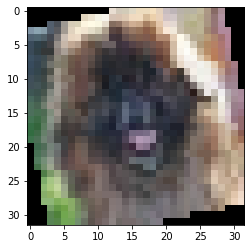

cat


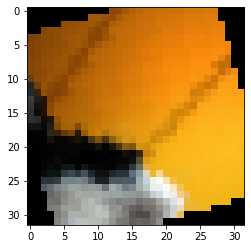

deer


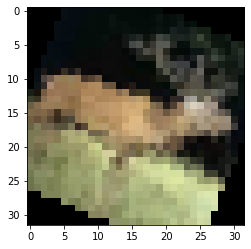

horse


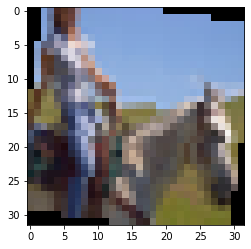

bird


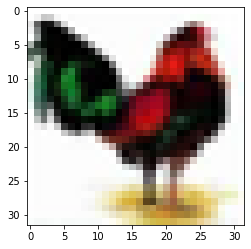

In [6]:
# Plot some images with corresponding labels
show5(trainloader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [7]:
## YOUR CODE HERE ##
input_size = np.prod(list(images.shape)[-3 : ]) 
first_hidden_sizes = np.array([int(input_size / 2) , int(input_size / 4)])
Second_hidden_sizes = np.divide(first_hidden_sizes, 2).astype(int)
output_size = len(classes)

# Build a feed-forward network
model = nn.Sequential(nn.Linear(input_size, first_hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(first_hidden_sizes[0], first_hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(Second_hidden_sizes[0], Second_hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(Second_hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))      
print(model)

Sequential(
  (0): Linear(in_features=3072, out_features=1536, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1536, out_features=768, bias=True)
  (3): ReLU()
  (4): Linear(in_features=768, out_features=384, bias=True)
  (5): ReLU()
  (6): Linear(in_features=384, out_features=10, bias=True)
  (7): LogSoftmax(dim=1)
)


Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [8]:
## YOUR CODE HERE ##
criterion = nn.NLLLoss() # since the output of the network is LogSoftmax
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Define the optimize
optimizer = optim.SGD( model.parameters(), lr=2e-3, momentum=0.85)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [9]:
## YOUR CODE HERE ##
print(f"Used Device: {device} ... Model on GPU: {next(model.parameters()).is_cuda} ...")

epochs = 25
min_validation_loss = np.Inf
train_log = {
    "train_losses" : list(),
    "validation_losses" : list(),
    "validation_accuracy" : list()
}
for epoch in range(epochs):
    
    # Training
    train_loss = 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        images = images.view(images.shape[0], -1)
        start_train = datetime.now() 
        logps = model.forward(images)
        loss = criterion(logps, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    end_train = datetime.now() 

    # Validation 
    validation_loss = 0
    accuracy = 0
    model.eval()
    with torch.no_grad():
        for images, labels in validloader:
            images, labels = images.to(device), labels.to(device)
            images = images.view(images.shape[0], -1)
            logps = model(images)
            batch_loss = criterion(logps, labels)
            validation_loss += batch_loss.item()

            # Accuracy Calculation
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
    model.train()

    # Results
    avg_train_loss = train_loss/len(trainloader)
    avg_validation_loss = validation_loss/len(validloader)
    avg_validation_acc = accuracy/len(validloader)
    train_log["train_losses"].append(avg_train_loss)
    train_log["validation_losses"].append(avg_validation_loss)
    train_log["validation_accuracy"].append(avg_validation_acc)
    print(f"Epoch {epoch+1}/{epochs}\t"
          f"Train loss: {avg_train_loss:.3f}\t"
          f"validation loss: {avg_validation_loss:.3f}\t"
          f"validation accuracy: {avg_validation_acc:.3f}")
        
    # Save best model 
    if avg_validation_loss < min_validation_loss:
        torch.save(model.state_dict(), "checkpoint.pth")
        print(f"\t\t##### Found a better model and saved ####")
        min_validation_loss = avg_validation_loss
    
print(f"Training Time: {(end_train - start_train).total_seconds():.4f}")

Used Device: cuda ... Model on GPU: True ...
Epoch 1/25	Train loss: 1.959	validation loss: 1.799	validation accuracy: 0.356
		##### Found a better model and saved ####
Epoch 2/25	Train loss: 1.745	validation loss: 1.711	validation accuracy: 0.384
		##### Found a better model and saved ####
Epoch 3/25	Train loss: 1.663	validation loss: 1.652	validation accuracy: 0.410
		##### Found a better model and saved ####
Epoch 4/25	Train loss: 1.609	validation loss: 1.631	validation accuracy: 0.413
		##### Found a better model and saved ####
Epoch 5/25	Train loss: 1.565	validation loss: 1.653	validation accuracy: 0.407
Epoch 6/25	Train loss: 1.530	validation loss: 1.561	validation accuracy: 0.444
		##### Found a better model and saved ####
Epoch 7/25	Train loss: 1.502	validation loss: 1.530	validation accuracy: 0.450
		##### Found a better model and saved ####
Epoch 8/25	Train loss: 1.472	validation loss: 1.480	validation accuracy: 0.476
		##### Found a better model and saved ####
Epoch 9/25	Trai

Plot the training loss (and validation loss/accuracy, if recorded).

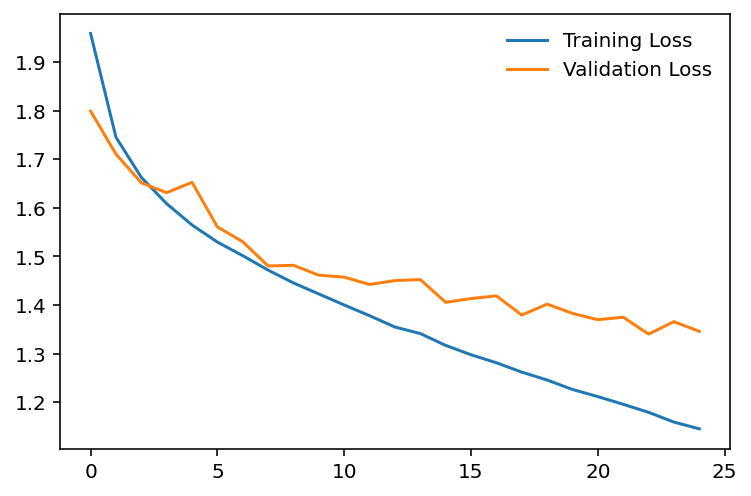

In [10]:
## YOUR CODE HERE ##
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
plt.plot(train_log["train_losses"], label='Training Loss')
plt.plot(train_log["validation_losses"], label='Validation Loss')
plt.legend(frameon=False)

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [11]:
state_dict = torch.load("checkpoint.pth")
state_dict.keys()

odict_keys(['0.weight', '0.bias', '2.weight', '2.bias', '4.weight', '4.bias', '6.weight', '6.bias'])

In [12]:
# load the best model 
state_dict = torch.load("checkpoint.pth")
best_model = model
best_model.load_state_dict(state_dict)
best_model.to(device)

test_accuracy = 0

best_model.eval()
with torch.no_grad():
    for images, labels in testloader:
        
        images, labels = images.to(device), labels.to(device)
        images = images.view(images.shape[0], -1)
        start_inference = datetime.now()
        logps = best_model(images)
        
        # Calculate accuracy
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(top_class.shape)
        test_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
    
    print(f"Test accuracy: {test_accuracy/len(testloader)*100:.2f}% in {len(testloader)} Test Images")
    print(f"Inference Time: {(datetime.now() - start_inference).total_seconds():.4f}")

Test accuracy: 55.04% in 1250 Test Images
Inference Time: 0.0006


## Saving your model
Using `torch.save`, save your model for future loading.

In [13]:
state_dict = torch.load('checkpoint.pth')
print(state_dict.keys())

odict_keys(['0.weight', '0.bias', '2.weight', '2.bias', '4.weight', '4.bias', '6.weight', '6.bias'])


## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

Some things to consider as you formulate your recommendation:
* How does your model compare to Detectocorp's model?
* How does it compare to the far more advanced solutions in the literature? 
* What did you do to get the accuracy you achieved? 
* Is it necessary to improve this accuracy? If so, what sort of work would be involved in improving it?

**Answer**
* we can improve our model in several direction; first of all we may inject gaussian noise to the data set in order to prevent overfitting, of course the right hyper-parameter tuning should be done further.
* Weak but it can be improved 
* ~55 % of accuracy
* Probably we can try different nerual network architecture, spend some more time on hyperparameter tuning, and data augmentation.
Maybe there will be double decsent behavior then we can reduce the learning rates of the last half of the network. see -> https://pytorch.org/docs/stable/optim.html#per-parameter-options
 




## Submit Your Project

When you are finished editing the notebook and are ready to turn it in, simply click the **SUBMIT PROJECT** button in the lower right.

Once you submit your project, we'll review your work and give you feedback if there's anything that you need to work on. If you'd like to see the exact points that your reviewer will check for when looking at your work, you can have a look over the project [rubric](https://review.udacity.com/#!/rubrics/3077/view).